In [16]:
##############################################################################
#                            ADA BOOST CLASSIFIER
##############################################################################

########## TABLE OF CONTENTS #############
#1. DATA READ IN
#2. DATA QUALITY CHECK
#3. DATA PREPARATION
#4. MODEL TRAINING -  BEST HYPER PARAMS SEARCH - RandomizedSearchCV
#5. MODEL TRAINING - MODEL DEVELOPMENT
#6. MODEL PERFORMANCE EVALUATION
#7. NEW MODEL - BEST HYPER PARAMS SEARCH - Compare Train vs Test Gini's to ensure lowest variance (limit overfitting)
#8. NEW MODEL TRAINING -> NOT PERFORMED -> AWFUL RESULTS FROM STEP 7
#9. NEW MODEL PERFORMANCE EVALUATION -> NOT PERFORMED -> AWFUL RESULTS FROM STEP 7

# Dataset -> Heart -> Taken from https://hastie.su.domains/ElemStatLearn/
# WARNING -> TOO FEW RECORDS TO PERFORM AN ADVANCED ML ALGO -> DONE IT FOR DEMO PURPOSES !
######################

# Boosting - An ensemble model is created to decrease model bias using a boosting approach.
# Boosting algorithms are a set of the weak classifiers to create a strong classifier.
# Strong classifiers offer error rate close to 0.
# Boosting algorithm can track the model who failed the accurate prediction.
# Boosting algorithms are less affected by the overfitting problem.

# ADA Boost steps:
# Initially, all observations are given equal weights.
# A model is built on a subset of data.
# Using this model, predictions are made on the whole dataset.
# Errors are calculated by comparing the predictions and actual values.
# While creating the next model, higher weights are given to the data points which were predicted incorrectly.
# Weights can be determined using the error value. For instance,the higher the error the more is the weight assigned 
    # to the observation.
# This process is repeated until the error function does not change, or the maximum limit of the number of estimators is reached.



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
import scipy 
from scipy import stats 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, auc
import statsmodels.formula.api as smf
import math
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import RandomizedSearchCV, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
import shap 
from shap import TreeExplainer, Explanation
from shap.plots import waterfall
from sklearn.model_selection import learning_curve

1. DATA READ IN

In [2]:
df = pd.read_csv("Heart.txt", index_col=0)
df

df['TrainTestFlag'] = 0
df.iloc[pd.Series(df.index).sample(frac=0.5, random_state=1234), df.columns.get_loc('TrainTestFlag')] = 1
print("Train vs Test sample")
print(df['TrainTestFlag'].value_counts())
print("")
print(df['chd'].value_counts())
print("")
df.shape
df.info()


# sbp		systolic blood pressure
# tobacco	cumulative tobacco (kg)
# ldl		low densiity lipoprotein cholesterol
# adiposity
# famhist	family history of heart disease (Present, Absent)
# typea		type-A behavior
# obesity
# alcohol	current alcohol consumption
# age		age at onset
# chd		response, coronary heart disease  -> TARGET VARIABLE


Train vs Test sample
TrainTestFlag
0    231
1    231
Name: count, dtype: int64

chd
0    302
1    160
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 1 to 463
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sbp            462 non-null    int64  
 1   tobacco        462 non-null    float64
 2   ldl            462 non-null    float64
 3   adiposity      462 non-null    float64
 4   famhist        462 non-null    object 
 5   typea          462 non-null    int64  
 6   obesity        462 non-null    float64
 7   alcohol        462 non-null    float64
 8   age            462 non-null    int64  
 9   chd            462 non-null    int64  
 10  TrainTestFlag  462 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 43.3+ KB


2. DATA QUALITY CHECK

Checking duplicates
0

Univariate Analysis


,Feature,Feature Type,# Records,# Zero's,% Zero's,# Missing,% Missing,Minimum,Mean,Median,Maximum,Skewness,Kurtosis,Normality (p > 0.05)
0,sbp,int64,462.0,0.0,0.00,0.0,0.0,101.00,138.33,134.00,218.00,1.18,1.78,0.000
0,tobacco,float64,462.0,107.0,2.11,0.0,0.0,0.00,3.64,2.00,31.20,2.08,5.97,0.000
0,ldl,float64,462.0,0.0,0.00,0.0,0.0,0.98,4.74,4.34,15.33,1.31,2.88,0.000
0,adiposity,float64,462.0,0.0,0.00,0.0,0.0,6.74,25.41,26.12,42.49,-0.21,-0.70,0.000
0,typea,int64,462.0,0.0,0.00,0.0,0.0,13.00,53.10,53.00,78.00,-0.35,0.47,0.002
0,obesity,float64,462.0,0.0,0.00,0.0,0.0,14.70,26.04,25.80,46.58,0.91,2.26,0.000
0,alcohol,float64,462.0,110.0,2.16,0.0,0.0,0.00,17.04,7.51,147.19,2.31,6.42,0.000
0,age,int64,462.0,0.0,0.00,0.0,0.0,15.00,42.82,45.00,64.00,-0.38,-1.02,0.000
0,chd,int64,462.0,302.0,5.94,0.0,0.0,0.00,0.35,0.00,1.00,0.65,-1.59,0.000
0,familiarity,int32,462.0,270.0,5.31,0.0,0.0,0.00,0.42,0.00,1.00,0.34,-1.89,0.000




Train Sample - Correlation Analysis


,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,familiarity
sbp,1.000000,0.233283,0.207580,0.385809,0.006982,0.234404,0.056174,0.374447,0.193223,-0.012011
tobacco,0.233283,1.000000,0.178263,0.301028,-0.019072,0.149317,0.121970,0.470611,0.235672,0.059423
ldl,0.207580,0.178263,1.000000,0.506813,-0.034983,0.350632,-0.019253,0.359990,0.219369,0.178233
adiposity,0.385809,0.301028,0.506813,1.000000,-0.099006,0.671724,0.090994,0.626552,0.246833,0.135851
typea,0.006982,-0.019072,-0.034983,-0.099006,1.000000,0.059974,0.089611,-0.130366,0.051555,-0.005536
obesity,0.234404,0.149317,0.350632,0.671724,0.059974,1.000000,0.033501,0.289105,0.106953,0.059364
alcohol,0.056174,0.121970,-0.019253,0.090994,0.089611,0.033501,1.000000,0.132030,0.068481,0.123137
age,0.374447,0.470611,0.359990,0.626552,-0.130366,0.289105,0.132030,1.000000,0.363721,0.216936
chd,0.193223,0.235672,0.219369,0.246833,0.051555,0.106953,0.068481,0.363721,1.000000,0.247746
familiarity,-0.012011,0.059423,0.178233,0.135851,-0.005536,0.059364,0.123137,0.216936,0.247746,1.000000


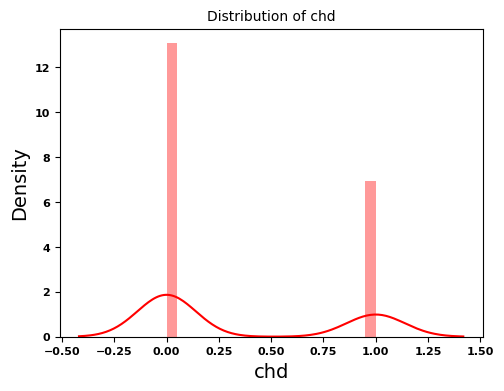

In [3]:
df = pd.read_csv("Heart.txt", index_col=0)
df['familiarity'] = np.where(df['famhist'] == "Absent",0,np.where(df['famhist'] == "Present",1,-1))

df = df.drop(columns=['famhist'], axis=1)

df['TrainTestFlag'] = 0
df.iloc[pd.Series(df.index).sample(frac=0.5, random_state=1234), df.columns.get_loc('TrainTestFlag')] = 1

# Check for exact duplicates
print("Checking duplicates")
print(df.duplicated(keep=False).sum())
print("")
# Univariate Analysis
print("Univariate Analysis")
chars = df.columns

d = pd.DataFrame(index = [0],columns=['Feature','Feature Type','# Records',"# Zero's","% Zero's","# Missing","% Missing","Minimum", "Mean", "Median", "Maximum", "Skewness","Kurtosis","Normality (p > 0.05)"])
d.to_csv('univariateAnalysis.csv')      

notApplicable = "N/A"
for z in range(len(chars)):
    a = pd.read_csv('univariateAnalysis.csv',index_col=0)  
    if(df[chars[z]].dtype !='object'):
        k2, p = stats.normaltest(df[chars[z]])
        dd = pd.DataFrame({'Feature':[chars[z]],
                            'Feature Type':df[chars[z]].dtype,
                            "# Records":len(df),
                            "# Zero's": (df[chars[z]] == 0).sum(),
                            "% Zero's" : round((df[chars[z]] == 0).sum()/df.size*100,2),
                            "# Missing" : (df[chars[z]].isna()).sum(),
                            "% Missing" : round((df[chars[z]].isna()).sum()/df.size*100,2),
                            "Minimum" : round(df[chars[z]].min(),2),
                            "Mean" : round(df[chars[z]].mean(),2),
                            "Median" : round(df[chars[z]].median(),2),
                            "Maximum" : round(df[chars[z]].max(),2),
                            "Skewness" : round(df[chars[z]].skew(),2), #Positive Skewness -> LEFT SKEW -> -> Threshold is -0.5 < x < 0.5
                            "Kurtosis" : round(df[chars[z]].kurt(),2), #Negative Kurtosis -> FAT TAILS -> -> Threshold is 3
                            "Normality (p > 0.05)" : round(p,3)}
                            )
        s = pd.concat([a, dd])
        s = s.dropna()
        s.to_csv('univariateAnalysis.csv')

    else:
        dd = pd.DataFrame({'Feature':[chars[z]],
                    'Feature Type':df[chars[z]].dtype,
                    "# Records": len(df),
                    "# Zero's": (df[chars[z]] == 0).sum(),
                    "% Zero's" : round((df[chars[z]] == 0).sum()/len(df)*100,1),
                    "# Missing" : (df[chars[z]].isna()).sum(),
                    "% Missing" : round((df[chars[z]].isna()).sum()/df.size*100,1),
                    "Minimum" : [notApplicable],
                    "Mean" : [notApplicable],
                    "Median" : [notApplicable],
                    "Maximum" : [notApplicable],
                    "Skewness" : [notApplicable],
                    "Kurtosis" : [notApplicable],
                    "Normality (p > 0.05)" : [notApplicable]}
                    )

        s = pd.concat([a, dd])
        s = s.dropna()
        s.to_csv('univariateAnalysis.csv')
display(s)
print("")


# Distribution of target variable
f= plt.figure(figsize=(12,4))
ax=f.add_subplot(121)
ax.tick_params(axis='both', which='major', labelsize=8)
sns.distplot(df['chd'],bins=20,color='r',ax=ax)
ax.set_title('Distribution of chd',fontsize = 10)



#Split Train vs Test -> 50% vs 50%
train = df.loc[df['TrainTestFlag'] == 1]
test = df.loc[df['TrainTestFlag'] == 0]


# Correlation
# Do I need to remove correlated features? 
# The short answer is no. It does not affect prediction accuracy.
# But do correlation anaylysis anyway.

print("")
print("Train Sample - Correlation Analysis")
ds = train.drop(columns=['TrainTestFlag'], axis=1)
corr = ds.corr()
display(corr.style.background_gradient(cmap='coolwarm'))
print("")


3. DATA PREPARATION

In [4]:
X = ds.drop(columns=['chd'], axis = 1)
Y = ds['chd']

pred_features = X.columns
print(pred_features)

Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol',
       'age', 'familiarity'],
      dtype='object')


4. MODEL TRAINING -  BEST HYPER PARAMS SEARCH - RandomizedSearchCV

In [23]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.50, random_state = 42)

abc = AdaBoostClassifier()


parameters = {'n_estimators':[i for i in range(1,11,2)],
              'learning_rate':[0,0.05,0.1,0.2,0.3,0.5,1],
              'random_state':[0,10,50,250,1000]}

clf = RandomizedSearchCV(estimator = abc,
                        param_distributions = parameters,
                        n_iter = 100, 
                        cv = 3, 
                        verbose=2, 
                        random_state=42, 
                        n_jobs = -1)
clf.fit(X_train,y_train)
clf.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'random_state': 0, 'n_estimators': 5, 'learning_rate': 0.1}

5. MODEL TRAINING - MODEL DEVELOPMENT

age            0.8
typea          0.2
sbp            0.0
tobacco        0.0
ldl            0.0
adiposity      0.0
obesity        0.0
alcohol        0.0
familiarity    0.0
dtype: float64


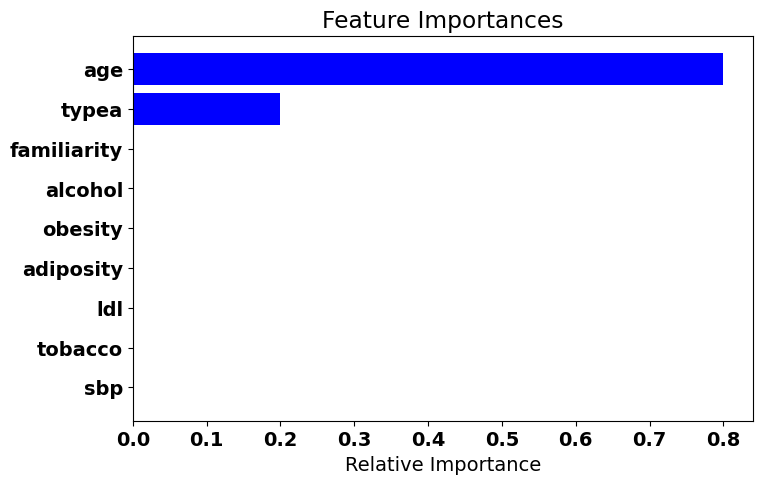

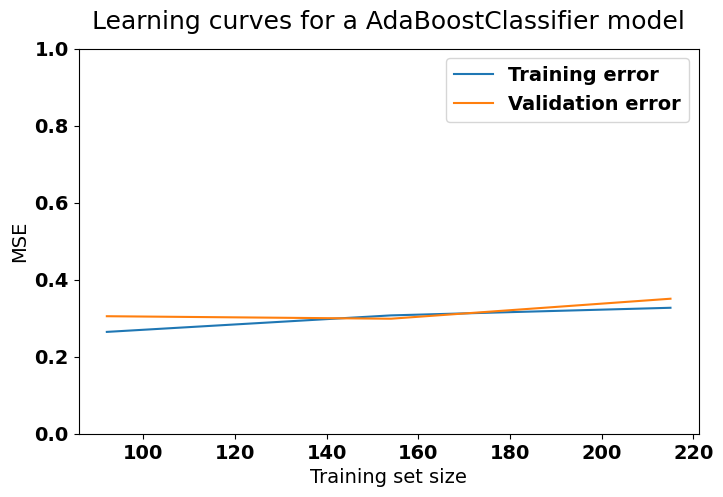

In [52]:

clf = AdaBoostClassifier(
                    random_state= 0,
                    n_estimators= 5, 
                    learning_rate= 0.1
                )

# Train Adaboost Classifer
model = clf.fit(X_train, y_train)

# Print features importance
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

# Plot features importance
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [pred_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Create Tree Explainer object that can calculate shap values
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")

# print("")


# Plot Learning Curve
def learning_curves(estimator, data, features, target, train_sizes , cv):
    train_sizes, train_scores, validation_scores = learning_curve(
    estimator, data[features], data[target], train_sizes =  train_sizes ,
    cv = cv, scoring = 'neg_mean_squared_error')
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    plt.ylabel('MSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,1)

train_sizes = [0.3,0.5,0.7]
learning_curves(clf, df, pred_features, 'chd', train_sizes, 3)

6. MODEL EVALUATION

Model accuracy score on Train Sample : 0.7130
Model accuracy score on Test Sample: 0.6810
Confusion matrix

 [[76  1]
 [36  3]]
              precision    recall  f1-score   support

           0       0.68      0.99      0.80        77
           1       0.75      0.08      0.14        39

    accuracy                           0.68       116
   macro avg       0.71      0.53      0.47       116
weighted avg       0.70      0.68      0.58       116

Gini for Train Sample is 49.624



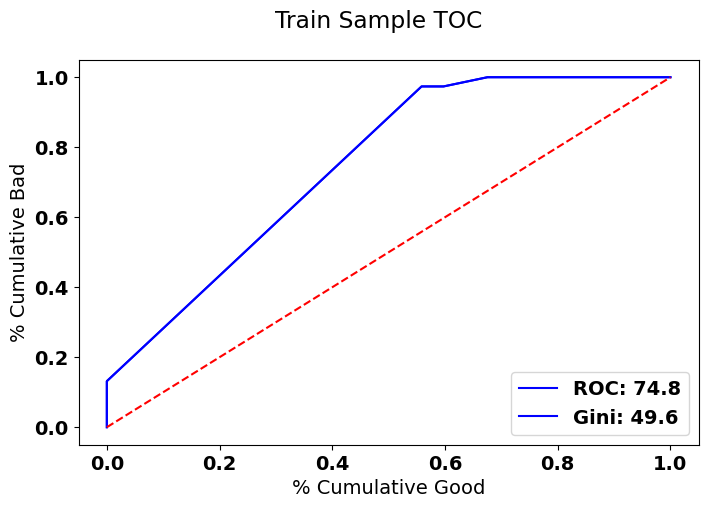

Gini for Test Sample is 35.498



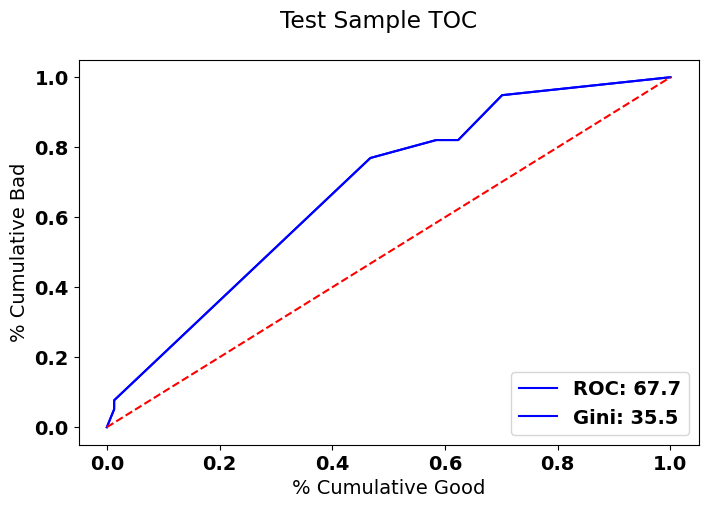

In [53]:
# Accuracy Score on Train Sample
y_pred = clf.predict(X_train)
print('Model accuracy score on Train Sample : {0:0.4f}'. format(accuracy_score(y_train, y_pred)))

#Accuracy Score on Train Sample
y_pred = clf.predict(X_test)
print('Model accuracy score on Test Sample: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

# Confusion Matrix (on Test Sample)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))
    
# Gini calculation on Train Sample
y_pred_proba = clf.predict_proba(X_train)[:,1]
[fpr, tpr, thr] = roc_curve(y_train, y_pred_proba)
rocauc=auc(fpr,tpr)*100
Gini = (auc(fpr, tpr)-0.5)*200
print("Gini for Train Sample is %2.3f" % Gini)
print("")

fig = plt.figure()    
fig.suptitle('Train Sample TOC')
ax1 = fig.add_subplot(1,1,1)
plt.plot(fpr,tpr,'b',label='ROC: %0.1f'% rocauc)
plt.plot(fpr,tpr,'b',label='Gini: %0.1f'% Gini)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('% Cumulative Good')
plt.ylabel('% Cumulative Bad')
plt.show()


    
# Gini calculation on Test Sample
y_pred_proba = clf.predict_proba(X_test)[:,1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
rocauc=auc(fpr,tpr)*100
Gini = (auc(fpr, tpr)-0.5)*200
print("Gini for Test Sample is %2.3f" % Gini)
print("")

fig = plt.figure()    
fig.suptitle('Test Sample TOC')
ax1 = fig.add_subplot(1,1,1)
plt.plot(fpr,tpr,'b',label='ROC: %0.1f'% rocauc)
plt.plot(fpr,tpr,'b',label='Gini: %0.1f'% Gini)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('% Cumulative Good')
plt.ylabel('% Cumulative Bad')
plt.show()


7. NEW MODEL - BEST HYPER PARAMS SEARCH - Compare Train vs Test Gini's to ensure lowest variance (limit overfitting)

1
Number of Iterations
1584


,n_estimators,learning_rate,Train Gini,Test Gini,random_state
0,1.0,0.01,0.376282,0.210456,0.0
0,1.0,0.02,0.376282,0.210456,0.0
0,1.0,0.03,0.376282,0.210456,0.0
0,1.0,0.05,0.376282,0.210456,0.0
0,1.0,0.06,0.376282,0.210456,0.0
...,...,...,...,...,...
0,99.0,0.50,1.000000,0.204795,0.0
0,99.0,0.75,1.000000,0.188811,0.0
0,99.0,1.00,1.000000,0.232767,0.0
0,99.0,1.50,1.000000,0.007659,0.0


,Unnamed: 0,n_estimators,learning_rate,Train Gini,Test Gini,random_state,Gini Difference
226,0,15.0,0.03,0.592618,0.435564,0.0,-0.157053
242,0,16.0,0.03,0.592618,0.435564,0.0,-0.157053
353,0,23.0,0.02,0.592618,0.435564,0.0,-0.157053
369,0,24.0,0.02,0.592618,0.435564,0.0,-0.157053
385,0,25.0,0.02,0.592618,0.435564,0.0,-0.157053
...,...,...,...,...,...,...,...
253,0,16.0,1.00,0.924129,0.006993,0.0,-0.917135
365,0,23.0,1.00,0.963773,0.002997,0.0,-0.960776
414,0,26.0,1.50,0.995215,0.002664,0.0,-0.992551
589,0,37.0,1.00,0.999316,0.001665,0.0,-0.997651


Text(0, 0.5, 'Test Gini')

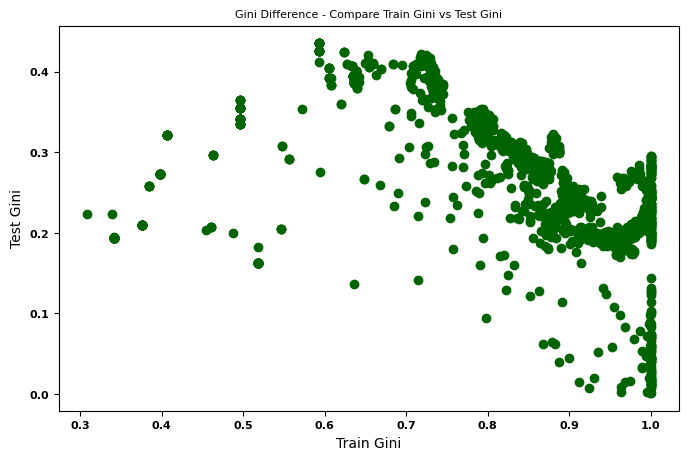

In [54]:
if True:
    d = pd.DataFrame(index = [0],columns=['n_estimators','learning_rate',"Train Gini", "Test Gini"])
    d.to_csv('ADA_boost_HyperParams.csv')      

    random_state= 0
    n_estimators = list((range(1,100,1)))
    print(n_estimators[0])
    learning_rate = [0.01, 0.02, 0.03, 0.05, 0.06, 0.08, 0.1, 0.15, 0.20, 0.25, 0.30, 0.5, 0.75, 1, 1.5, 2]

    print("Number of Iterations")
    print(len(n_estimators)  * len(learning_rate))

    for i in range(len(n_estimators)):
        for j in range(len(learning_rate)):

            clf = AdaBoostClassifier(
                                random_state= 0,
                                n_estimators= n_estimators[i], 
                                learning_rate= learning_rate[j]
                            )

            clf.fit(X_train, y_train)


            # Gini calculation on Train Sample
            y_pred_proba = clf.predict_proba(X_train)[:,1]
            [fpr, tpr, thr] = roc_curve(y_train, y_pred_proba)
            GiniTrain = (auc(fpr, tpr)-0.5)*2

                
            # Gini calculation on Test Sample
            y_pred_proba = clf.predict_proba(X_test)[:,1]
            [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
            GiniTest = (auc(fpr, tpr)-0.5)*2

            # Fit the model to the training set
            clf.fit(X_train, y_train)

            a = pd.read_csv('ADA_boost_HyperParams.csv',index_col=0)  
            dd = pd.DataFrame(
                                {'n_estimators':[n_estimators[i]],
                                'random_state' : 0,
                                'learning_rate':learning_rate[j],
                                "Train Gini" : GiniTrain,
                                "Test Gini" : GiniTest
                                }
                                )
            s = pd.concat([a, dd])
            s = s.dropna()
            s.to_csv('ADA_boost_HyperParams.csv')

    display(s)

s = pd.read_csv("ADA_boost_HyperParams.csv")
s['Gini Difference'] = s['Test Gini'] - s['Train Gini']
s = s.loc[s['Test Gini'] > 0]
dd = s.sort_values(by=['Test Gini','Gini Difference'], ascending=False)
display(dd)

fig = plt.figure()

ax1 = fig.add_subplot(111)
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.scatter(x=s['Train Gini'],
                    y=s['Test Gini'],
                    c='DarkGreen')
ax1.set_title("Gini Difference - Compare Train Gini vs Test Gini", fontsize=8)
ax1.set_xlabel("Train Gini", fontsize = 10)
ax1.set_ylabel("Test Gini", fontsize = 10)